# **Inception v3 from scratch**

> This project focuses on the concepts of "[Going deeper with convolutions](https://arxiv.org/abs/1409.4842)" which gave birth to the concept of Inception module. Inception network was once considered the "state-of-the-art" deep learning architecture for image recognition and detection tasks.
And the implemented of Inception v3 from [Rethinking the Inception Architecture for Computer Vision](http://arxiv.org/abs/1512.00567) 

  ![We need to go deeper](https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg)


## The complete architeciture of GoogLeNet - The one where it all started



![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20200429201549/Inceptionv1_architecture.png)

Now let's talk about the famous Inception Layer of GoogLeNet : <br>
>  *Inception Layer is a combination of all 3 layers* : 
  - 1x1 convolutional layer
  - 3x3 convolutional layer
  - 5x5 convolutional layer <br>
    *with their output feature maps concatenated into a single output which forms a input to the next layer.*

![Inception module](https://www.researchgate.net/profile/Bo_Zhao48/publication/312515254/figure/fig3/AS:489373281067012@1493687090916/nception-module-of-GoogLeNet-This-figure-is-from-the-original-paper-10.png)

So, the output will be something like : <br><br>
![Inception module](https://i.ytimg.com/vi/VxhSouuSZDY/maxresdefault.jpg)



In [1]:
"""Inception V3 model for Keras.
Note that the input image format for this model is different than for
the VGG16 and ResNet models (299x299 instead of 224x224),
and that the input preprocessing function is also different (same as Xception).
"""

import os
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.backend import image_data_format
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.utils import get_file
from keras.applications.inception_v3 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import keras.backend as K
import imutils


WEIGHTS_PATH = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

Using TensorFlow backend.


## **Inception v3 Architecture**

![](https://miro.medium.com/max/875/1*gqKM5V-uo2sMFFPDS84yJw.png)

In [2]:
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

---
## Inception v3 modules





Inception v3 introduced 3 different inception modules to improve training speed and accuracy.

### ***Inception module A***

![](https://miro.medium.com/max/846/1*SioPsPvzJcbFdBYd-0ftrQ.png)


In [3]:
def inceptionModuleA(x,unique_filters,concat_axis,name=None):
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, unique_filters, 1, 1)
    x = concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=concat_axis,
        name='mixed'+name)
    return x


### ***Inception module B***

![](https://miro.medium.com/max/875/1*-djBF7AjzFNug1ZnVrv_2g.png)


In [4]:
def inceptionModuleB(x,unique_filters,concat_axis,name=None):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, unique_filters, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, unique_filters, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, unique_filters, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, unique_filters, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, unique_filters, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, unique_filters, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=concat_axis,
        name='mixed' + name)
    return x


### ***Inception module C***

![](https://miro.medium.com/max/705/1*77YxO_lknTTMcuqnJHfXJw.png)

In [5]:
def inceptionModuleC(x,concat_axis,name=None):
    branch1x1 = conv2d_bn(x, 320, 1, 1)

    branch3x3 = conv2d_bn(x, 384, 1, 1)
    branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
    branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
    branch3x3 = concatenate(
        [branch3x3_1, branch3x3_2],
        axis=concat_axis,
        name='mixed9_' + name)

    branch3x3dbl = conv2d_bn(x, 448, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
    branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
    branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
    branch3x3dbl = concatenate(
        [branch3x3dbl_1, branch3x3dbl_2], axis=concat_axis)

    branch_pool = AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate(
        [branch1x1, branch3x3, branch3x3dbl, branch_pool],
        axis=concat_axis,
        name='mixed' + str(9 + int(name)))
    return x

##Fixing all the pieces together

In [6]:
def auxiliary_classifier(x,num_classes):
    x1 = AveragePooling2D((5,5),strides=(3,3))(x)
    x1 = conv2d_bn(x1, 128,1,1)
    x1 = Dense(num_classes, activation='softmax',name='auxillary_classifier')(x1)
    return x1

In [7]:
def load_weights(model,weights,include_top):
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = keras_utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    
    return model

In [8]:

def InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    """Instantiates the Inception v3 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 75.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
#     global backend, layers, models, keras_utils
#     backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=75,
        data_format=image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)


    # mixed 0: 35 x 35 x 256
    x = inceptionModuleA(x,32,channel_axis,"0")
    # mixed 1: 35 x 35 x 288
    x = inceptionModuleA(x,64,channel_axis,"1")
    # mixed 2: 35 x 35 x 288
    x = inceptionModuleA(x,64,channel_axis,"2")


    # mixed 3: 17 x 17 x 768
    #Grid Size Reduction with some modifications
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # mixed 4: 17 x 17 x 768
    x = inceptionModuleB(x,128,channel_axis,"4")
    # mixed 5, 6: 17 x 17 x 768
    x = inceptionModuleB(x,160,channel_axis,"5")
    x = inceptionModuleB(x,160,channel_axis,"6")
    # mixed 7: 17 x 17 x 768
    x = inceptionModuleB(x,192,channel_axis,"7")


    x1 = auxiliary_classifier(x,classes)

    # mixed 8: 8 x 8 x 1280
    #Grid Size reduction
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')


    # mixed 9: 8 x 8 x 2048
    x = inceptionModuleC(x,channel_axis,"1")
    x = inceptionModuleC(x,channel_axis,"2")


    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
    

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    
    # Create model.
    model = Model(inputs, x, name='inception_v3')

    # Load weights.
    model = load_weights(model,weights,include_top)
    print("Inception v3 model created")

    return model


In [9]:
model = InceptionV3()

Inception v3 model created


## Predictions

In [10]:
images_links = [
               "https://images.theconversation.com/files/243439/original/file-20181101-83635-1xcrr39.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=926&fit=clip",
               "https://assets.ray-ban.com/is/image/RayBan/805289004783_shad_qt?$594$",
               "https://i.ytimg.com/vi/7xh1DAKIdng/maxresdefault.jpg",
               "https://s.aolcdn.com/commerce/autodata/images/USC70TSC024B021001.jpg",
               "https://img1.grunge.com/img/gallery/the-real-reason-airplanes-are-almost-always-painted-white/intro-1567189774.jpg"
               ]
images=[]
predictions=[]

In [11]:
def resize_img(img):
  img = img[...,::-1]
  img = cv2.resize(img, (299,299))
  img = img.reshape(1, 299,299,3)
  img = preprocess_input(img)
  return img


def show_image(img,title=None):
    title_obj = plt.title(title.upper())
    plt.setp(title_obj,color='g')
    plt.imshow(img,interpolation=None)
    plt.show()

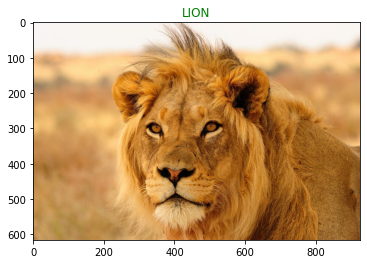

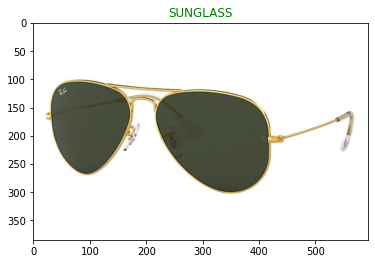

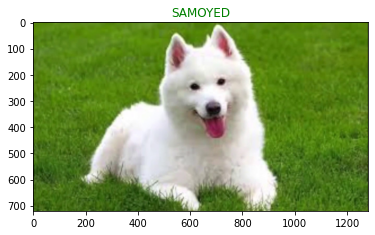

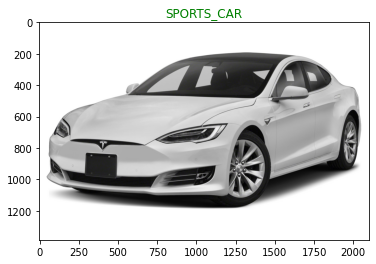

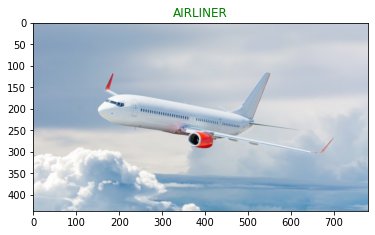

In [12]:
for img_url in images_links:
    image = imutils.url_to_image(img_url)
    img = resize_img(image)
    images.append(image[...,::-1])
    result = model.predict(img)
    pred = decode_predictions(result,top=5)
    predictions.append(pred[0][0][1])
    show_image(image[...,::-1],pred[0][0][1])
